# Experiment on Different Time-series Similarity Measures

### Loading

In [1]:
# load image and libraries
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from itertools import groupby
from scipy import signal
from sklearn import preprocessing
import pandas as pd
import time

np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 150 # 200 e.g. is really fine, but slower

root_path = './processed_datasets/'
datasets = ['has', 'sp', 'fp', 'rb', 'sd', 'sr', 'hasb', 'ihas']

# load ground truth
ori_data_X = []
ori_data_y = []
sketch_X = []
for dataset in datasets:
    file_name = root_path + 'original_' + dataset  
    ori_data_X.append(np.load(file_name + '_X' + '.npy'))
    ori_data_y.append(np.load(file_name + '_y' + '.npy'))
    file_name = root_path + 'sketch_' + dataset + '.npy'
    sketch_X.append(np.load(file_name, allow_pickle=True)[:100])
print(f"number of loaded samples per class: {[len(x) for x in sketch_X]}")
print(f"Original data: {len(ori_data_X)} datasets")
print(f"Sketch data: {len(sketch_X)} datasets")

number of loaded samples per class: [100, 100, 100, 100, 100, 100, 100, 100]
Original data: 8 datasets
Sketch data: 8 datasets


### Experiment Setups

#### Sliding Window

In [26]:
def sliding_window(ori_series, clip_series, measure):
    """
    Compute the similarities of the original and the clipped series using sliding window
    input: original time series, clipped series, similarity measure function
    output: similarity_distribution, matching result, i.e., starting and ending points
    """
    ori_len = ori_series.shape[0]
    clip_len = clip_series.shape[0]
    if ori_len < clip_len:
        return None

    # compute the similarity between the original and the clipped series
    dist = []
    # compute the similarity between the original and the clipped series using sliding window
    for i in range(ori_len - clip_len + 1):
        dist.append(measure(ori_series[i:i+clip_len], clip_series))
    # find the maximum similarity and the corresponding starting and ending points
    min_idx = np.argmin(dist)
    return dist, [min_idx, min_idx + clip_len - 1]

#### Pointwise distances
results: 
- (without precision check): list of eight lists, each list contains the list (100 corresponding skcteches vs current time series) of one similarity measure using sliding window, size (8 x 100 x dist_len)
- (with precision check): list of eight lists, each list contains the list (100 corresponding skcteches vs all 8 time series) of the mininum value in one similarity measure using sliding window, size (8 x 100 x 8)

In [27]:
def pointwise_distances(ori_data_X, ori_data_y, sketch_X, measure, check_precisons = False):
    results = []
    for i, dataset in enumerate(datasets):
        original = ori_data_X[i]
        label = ori_data_y[i]
        dummy_record = []
        for sample in sketch_X[i]:
            if not check_precisons:
                clip =  signal.resample(sample, label[1]-label[0]+1)
                sim_dist, pred_loc = sliding_window(original, clip, measure)
                dummy_record.append([sim_dist, pred_loc])
            else:
                dummy_record1 = []
                for i, dataset in enumerate(datasets):
                    original = ori_data_X[i]
                    label = ori_data_y[i]
                    clip =  signal.resample(sample, label[1]-label[0]+1)
                    sim_dist, _ = sliding_window(original, clip, measure)
                    dummy_record1.append(min(sim_dist))
                dummy_record.append(dummy_record1)
        results.append(dummy_record)
    return results

### Define Pointwiese Metrics

#### Euclidean Distance

In [28]:
def euclidean_distance(x,y):
    t = preprocessing.Normalizer()
    x = np.expand_dims(x, axis=0)
    y = np.expand_dims(y, axis=0)
    return np.linalg.norm(t.transform(x) - t.transform(y))

#### Manhattan Distance

In [29]:
def manhattan_distance(x,y):
    t = preprocessing.Normalizer()
    x = np.expand_dims(x, axis=0)
    y = np.expand_dims(y, axis=0)
    return np.abs(t.transform(x) - t.transform(y)).sum()

#### Dynamic Time Warping (DTW)
Based on tslearn: https://github.com/tslearn-team/tslearn/

In [30]:
from tslearn.metrics import dtw
def dtw_distance(x,y):
    t = preprocessing.Normalizer()
    x = np.expand_dims(x, axis=0)
    y = np.expand_dims(y, axis=0)
    return dtw(t.transform(x)[0], t.transform(y)[0])

#### Canonical Time Warping (CTW)
Based on tslearn: https://github.com/tslearn-team/tslearn/

Canonical Time Warping is a method to align time series under rigid registration of the feature space. It should not be confused with Dynamic Time Warping (DTW), though CTW uses DTW.

In [31]:
from tslearn.metrics import ctw
def ctw_distance(x,y):
    t = preprocessing.Normalizer()
    x = np.expand_dims(x, axis=0)
    y = np.expand_dims(y, axis=0)
    return ctw(t.transform(x)[0], t.transform(y)[0])

#### Longest Common Subsequence (LCSS)
Based on tslearn: https://github.com/tslearn-team/tslearn/

LCSS is computed by matching indexes that are met up until the eps threshold, so it leaves some points unmatched and focuses on the similar parts of two sequences. The matching can occur even if the time indexes are different, regulated through the delta parameter that defines how far it can go. To retrieve a meaningful similarity value from the length of the longest common subsequence, the percentage of that value regarding the length of the shortest time series is returned.

According to this definition, the values returned by LCSS range from 0 to 1, the highest value taken when two time series fully match, and vice-versa. Therefore, we deine the distance to be 1-similarity.

In [32]:
from tslearn.metrics import lcss
def lcss_distance(x,y):
    t = preprocessing.Normalizer()
    x = np.expand_dims(x, axis=0)
    y = np.expand_dims(y, axis=0)
    return 1 - lcss(t.transform(x)[0], t.transform(y)[0])

#### Soft-DTW
Based on tslearn: https://github.com/tslearn-team/tslearn/

Improves DTW by using soft-min operator.

In [33]:
from tslearn.metrics import soft_dtw
def sdtw_distance(x,y):
    t = preprocessing.Normalizer()
    x = np.expand_dims(x, axis=0)
    y = np.expand_dims(y, axis=0)
    return soft_dtw(t.transform(x)[0], t.transform(y)[0])

#### Global Alignment kernel (GAK)
Based on tslearn: https://github.com/tslearn-team/tslearn/

See also: M. Cuturi, “Fast global alignment kernels,” ICML 2011.

In [34]:
from tslearn.metrics import gak
def gak_distance(x,y):
    t = preprocessing.Normalizer()
    x = np.expand_dims(x, axis=0)
    y = np.expand_dims(y, axis=0)
    return 1 - gak(t.transform(x)[0], t.transform(y)[0])

### Define Qetch Algorithm

Implementation of Qetch algorithm for time series similarity search. The algorithm is described in the paper "Qetch: A Query-Driven Time Series Similarity Search Algorithm" by Y. Zhang, J. Wang, and J. Han, in Proceedings of the 2018 ACM SIGMOD International Conference on Management of Data (SIGMOD '18), June 2018.

#### Helper Functions for Qetch

##### Smoothing and geometric functions

In [10]:
def smoother(series,smoothing):
    series_df = pd.DataFrame(series,columns=['Data'])
    return series_df.ewm(alpha = np.exp(- 3 * smoothing)).mean().to_numpy() 

def width(series):
    # Should return width of series -  Size of a 1D array is the same as the length.
    return series.size
    
def height(series):
    #Finds Height of time series based difference in max and minimum values.
    h = np.max(series) - np.min(series) 
    return h

def heightGlobal(series):
    hmax = 0
    hmin = 999
    for i in series:
        hmax = max(np.max(i),hmax)
        hmin = min(np.min(i),hmin)

    h = hmax - hmin
    return h

def widthGlobal(series):
    return series.size

##### Spliter function for moontonicity segmentation

In [11]:
def Split_Correcter(split_arr, h_threshold):
    # Checks if the height is less than 1% of total height and mergers small segments.
    corr_split = []
    p = 0
    buff = []
    split_at = []
    counter = 0
    for i in split_arr:
        if(len(i) == 1 or (height(i) < h_threshold)):
            buff.append(i)
        else:
            if(len(buff) > 0):
                buff.append(i)
                temp = np.concatenate(buff)
                corr_split.append(temp)

                split_at.append(counter) #Starting position of segment is noted
                counter += temp.size
                buff = []
            else:
                split_at.append(counter) #Starting position of segment is noted
                counter += i.size
                corr_split.append(i)

    split_at.append(counter) # Adding the end position of the last segment

    return corr_split, len(corr_split), split_at

def split_based_derivative(series, c = False):

    if c:
        series = series.reshape(series.size)

    h_threshold = 0.01 * height(series)
    diff_arr = np.diff(series)
    sign_arr = np.sign(diff_arr)

    p = 0
    split_indices = []
    split_at = []
    for i in range(0, len(sign_arr)):
        if i == 0:
            p = sign_arr[i]
        else:
            if sign_arr[i] == 0 or sign_arr[i] == 1:
                if p == -1:
                    split_indices.append(i)
                    p = sign_arr[i]
            elif sign_arr[i] == -1 and (p==1 or p==0):
                split_indices.append(i)
                p = sign_arr[i]
    split_arr = np.split(series, split_indices, axis=0)
    corrected_split, k, split_at = Split_Correcter(split_arr,h_threshold)
    return corrected_split, k, split_at

#### Calculate intermediate and final metrics

In [12]:
def get_LDE(sketch_split, Candidate_split, Gx, Gy):
    Rx = width(Candidate_split) / (Gx * width(sketch_split))    
    Ry = height(Candidate_split) / (Gy * height(sketch_split))  
    return np.log(Rx) ** 2 + np.log(Ry) ** 2


def get_ShapeError(sketch_split, candidate_split,Gy):

    Ni = min(candidate_split.size, sketch_split.size)
    Sum_of_Shape = 0 

    resampled_sketch_split = signal.resample(sketch_split,Ni)
    resampled_candidate_split = signal.resample(candidate_split,Ni)

    Ry = height(resampled_candidate_split) / (Gy * height(resampled_sketch_split)) 


    for i in range(0, Ni):
        Sum_of_Shape += abs(((Gy*Ry*resampled_sketch_split[i]) - resampled_candidate_split[i]) / height(candidate_split))        

    return Sum_of_Shape / Ni
    
def calculateDistance(Sketch, Candidate,k):
    Sketch = np.array(Sketch)
    Candidate = np.array(Candidate)

    # Calculating Global non uniform Scaling factors
    Gx = widthGlobal(Candidate)/widthGlobal(Sketch)
    Gy = heightGlobal(Candidate)/heightGlobal(Sketch)

    # Calculating Local distortion and shape errors
    LDE = 0
    SE = 0
    for i in range(0, k-1):
        LDE += get_LDE(Sketch[i], Candidate[i], Gx, Gy)
        SE += get_ShapeError(Sketch[i], Candidate[i], Gy)

    # Calculating total error
    Dist = LDE + SE
    return Dist

## Experiments

### Experiment 1: Matching Performance

#### Accuracy Analysis Function

In [13]:
def accuracy_results(results, plot = True, show_table = True, ori_data_X=ori_data_X, ori_data_Y=ori_data_y, datasets=datasets):
    d = {'Dataset':[], 'Number of samples':[], 'Average distance':[], 'Average location error (%)':[]}
    for i in range(len(results)):
        d['Dataset'].append(datasets[i])
        d['Number of samples'].append(len(results[i]))
        d['Average distance'].append(np.mean([np.max(x[0]) for x in results[i]]))
        d['Average location error (%)'].append(np.mean([np.abs(x[1][0] - ori_data_y[i][0])/ ori_data_X[i].shape[0]*100 for x in results[i]]))
    df = pd.DataFrame(d)
    if show_table:
        display(df)
        display(df.iloc[:,[2,3]].describe())
        print(f'Average location error w.r.t. total length: {np.mean([np.mean([np.abs(x[1][0] - ori_data_y[i][0])/ ori_data_X[i].shape[0]*100 for x in results[i]]) for i in range(len(results))])}%')
    if plot:
        plt.figure()
        for i in range(len(results)):
            ax = plt.subplot(3,3,i+1)
            plt.tight_layout()
            plt.title(f"Dataset: {datasets[i]}")
            plt.xlabel("Time")
            plt.ylabel("Distance")
            # plt.plot(results[i][0][0])
            plt.plot(ori_data_X[i])
            plt.plot(results[i][0][1], [0.5, 0.5], marker='*', ls='none')
            plt.plot(ori_data_y[i], [0.5, 0.5], marker='o', color='r', ls='none')
        plt.legend(['Time Series', 'Predicted', 'Ground Truth'],bbox_to_anchor=(2,0), loc='lower right')
        plt.show()
    return df

#### Get results of pointwise metrics

In [15]:
measures = [euclidean_distance, manhattan_distance, dtw_distance, sdtw_distance, gak_distance]
# measures = []
results = []
d = {'Method':[], 'Average location error (%)':[], 'Running time (s)':[]}
for measure in measures:
    print(f"Measure: {measure.__name__}")
    d['Method'].append(measure.__name__)
    tic = time.time()
    results = pointwise_distances(ori_data_X, ori_data_y, sketch_X, measure)
    toc = time.time()
    print(f"Time elasped: {toc-tic} seconds")
    df = accuracy_results(results, plot = False)
    d['Average location error (%)'].append(df.iloc[:,3].mean())
    d['Running time (s)'].append(toc-tic)
    print('--------------------------------------------------------')
experiment_name = 'exp1'
np.save('./experiment_results/' + experiment_name + '.npy', results)

Measure: euclidean_distance
Time elasped: 15.705788850784302 seconds


,Dataset,Number of samples,Average distance,Average location error (%)
0,has,100,0.868820,7.251208
1,sp,100,0.894325,17.347826
2,fp,100,1.026507,12.874396
3,rb,100,1.139434,1.932367
4,sd,100,0.586013,3.045894
5,sr,100,1.239033,23.241546
6,hasb,100,0.669684,8.983092
7,ihas,100,0.752768,10.975904


,Average distance,Average location error (%)
count,8.000000,8.000000
mean,0.897073,10.706529
std,0.227572,7.137291
min,0.586013,1.932367
25%,0.731997,6.199879
50%,0.881572,9.979498
75%,1.054739,13.992754
max,1.239033,23.241546


Average location error w.r.t. total length: 10.706529014609162%
--------------------------------------------------------
Measure: manhattan_distance
Time elasped: 15.059736728668213 seconds


,Dataset,Number of samples,Average distance,Average location error (%)
0,has,100,8.285738,6.318841
1,sp,100,7.650034,16.613527
2,fp,100,8.144883,13.128019
3,rb,100,11.467559,1.734300
4,sd,100,3.066791,5.893720
5,sr,100,6.744708,18.533816
6,hasb,100,4.639287,9.557971
7,ihas,100,5.913132,10.867470


,Average distance,Average location error (%)
count,8.000000,8.000000
mean,6.989017,10.330958
std,2.553264,5.671422
min,3.066791,1.734300
25%,5.594671,6.212560
50%,7.197371,10.212720
75%,8.180097,13.999396
max,11.467559,18.533816


Average location error w.r.t. total length: 10.330957889529131%
--------------------------------------------------------
Measure: dtw_distance
Time elasped: 31.531152963638306 seconds


,Dataset,Number of samples,Average distance,Average location error (%)
0,has,100,0.678415,7.176329
1,sp,100,0.621693,12.927536
2,fp,100,0.707616,11.314010
3,rb,100,0.858138,1.553140
4,sd,100,0.442453,2.927536
5,sr,100,1.058595,16.120773
6,hasb,100,0.565764,19.599034
7,ihas,100,0.593285,2.886747


,Average distance,Average location error (%)
count,8.000000,8.000000
mean,0.690745,9.313138
std,0.190977,6.719575
min,0.442453,1.553140
25%,0.586405,2.917339
50%,0.650054,9.245169
75%,0.745247,13.725845
max,1.058595,19.599034


Average location error w.r.t. total length: 9.313138059484315%
--------------------------------------------------------
Measure: sdtw_distance
Time elasped: 132.89580488204956 seconds


,Dataset,Number of samples,Average distance,Average location error (%)
0,has,100,-235.436672,6.717391
1,sp,100,-193.261453,19.695652
2,fp,100,-168.186537,14.806763
3,rb,100,-220.459361,1.840580
4,sd,100,-83.364130,22.248792
5,sr,100,-100.714793,28.181159
6,hasb,100,-111.192918,8.980676
7,ihas,100,-144.356467,21.303614


,Average distance,Average location error (%)
count,8.000000,8.000000
mean,-157.121541,15.471829
std,56.653999,8.978810
min,-235.436672,1.840580
25%,-200.060930,8.414855
50%,-156.271502,17.251208
75%,-108.573387,21.539909
max,-83.364130,28.181159


Average location error w.r.t. total length: 15.47182861882312%
--------------------------------------------------------
Measure: gak_distance
Time elasped: 127.85099387168884 seconds


,Dataset,Number of samples,Average distance,Average location error (%)
0,has,100,0.675719,6.613527
1,sp,100,0.579123,14.695652
2,fp,100,0.721193,11.304348
3,rb,100,0.873772,1.760870
4,sd,100,0.302000,4.038647
5,sr,100,0.823351,19.929952
6,hasb,100,0.439828,8.442029
7,ihas,100,0.548762,9.903614


,Average distance,Average location error (%)
count,8.000000,8.000000
mean,0.620468,9.586080
std,0.192512,5.834742
min,0.302000,1.760870
25%,0.521529,5.969807
50%,0.627421,9.172822
75%,0.746732,12.152174
max,0.873772,19.929952


Average location error w.r.t. total length: 9.586079826552588%
--------------------------------------------------------


#### Get results of Qetch algorithm

In [16]:
def result_interpreter_error(results, ori_data_y, curve, length_of_original):
    error = np.mean([np.abs(x[1][0] - ori_data_y[curve][0]) / length_of_original * 100 for x in results])
    return error

def qetch_plus_accuracy(ori_data_X, ori_data_y, sketch_X, smooth_val_stepsize, curve):
    results = []
    original = ori_data_X[curve]
    length_of_original = original.shape[0]

    #Smoothing by factor of smooth_val_stepsize
    smoothed_candidate_list = []
    smooth_value_list = []
    smooth_value = 0.001
    while(smooth_value < 1):
        smoothed_candidate_list.append(smoother(original, smooth_value))
        smooth_value_list.append(smooth_value)
        smooth_value += smooth_val_stepsize

    smoothed_sketches = [smoother(sk, 0.3) for sk in sketch_X[curve]]
    for z in range(100):
        ResultDistanceObject = []
        testing_sketch = smoothed_sketches[z]
        split_sketch,k, Sketch_split_at = split_based_derivative(testing_sketch, True)

        for a in range(0,len(smoothed_candidate_list)):
            Candidate_split_at = []
            #Segments Loaded Data into T segments
            split_original,T,Candidate_split_at = split_based_derivative(smoothed_candidate_list[a], True)

            if T < k:
                ResultDistanceObject.append([999,[0,0], smooth_value_list[a], curve])
                # print("not possible") #Need to address case where this happens -> Smoothen Sketches with too much K
                continue
            itr = 0
            DistanceObject = []
            while itr <= T - k:
                distance = calculateDistance(split_sketch, split_original[itr:k+itr], k)
                #Add the starting and ending position Identified
                start_pos = Candidate_split_at[itr]
                end_pos = Candidate_split_at[itr+1]
                DistanceObject.append([distance,[start_pos,end_pos],smooth_value_list[a], curve])
                itr += 1
            ResultDistanceObject.append(min(DistanceObject, key = lambda sublist: sublist[0])) # Will Contain a list of T-k minimum distances
        results.append(min(ResultDistanceObject, key = lambda sublist: sublist[0])) # Should contain 100 minimum distances.
    op = result_interpreter_error(results, ori_data_y, curve, length_of_original)
    return op

In [17]:
error = []
smooth_val_stepsize = 0.05
for i in range(8):
    tic = time.time()
    error.append(qetch_plus_accuracy(ori_data_X, ori_data_y, sketch_X, smooth_val_stepsize, i))
    toc = time.time()
    print(f"Time elasped: {toc-tic} seconds")
d['Method'].append("Qetch")
d['Average location error (%)'].append(np.mean(error))
d['Running time (s)'].append(toc-tic)

Time elasped: 38.749165058135986 seconds
Time elasped: 66.31999611854553 seconds
Time elasped: 59.36249804496765 seconds
Time elasped: 6.872756004333496 seconds
Time elasped: 16.352911710739136 seconds
Time elasped: 27.526843309402466 seconds
Time elasped: 36.328505754470825 seconds
Time elasped: 33.96667218208313 seconds


#### Show results

In [18]:
df = pd.DataFrame(d)
display(df)

,Method,Average location error (%),Running time (s)
0,euclidean_distance,10.706529,15.705789
1,manhattan_distance,10.330958,15.059737
2,dtw_distance,9.313138,31.531153
3,sdtw_distance,15.471829,132.895805
4,gak_distance,9.586080,127.850994
5,Qetch,14.205751,33.966672


#### Frequency Analysis

In [19]:
measures = [euclidean_distance, manhattan_distance, dtw_distance, sdtw_distance, gak_distance]
# measures = []
average_power_spectrums = [np.mean(np.abs(np.fft.fft(x)) ** 2) for x in ori_data_X]
df0 = pd.DataFrame({'Average power spectrum':average_power_spectrums, 'Dataset':datasets})
df0 = df0.sort_values(by=['Average power spectrum'])
display(df0)
results = []
d = {'Spectrum':[], 'Method':[], 'Average location error (%)':[]}
for measure in measures:
    print(f"Measure: {measure.__name__}")
    results = pointwise_distances(ori_data_X, ori_data_y, sketch_X, measure)
    for i in range(len(results)):
        d['Method'].append(measure.__name__)
        d['Spectrum'].append(average_power_spectrums[i])
        d['Average location error (%)'].append(np.mean([np.abs(x[1][0] - ori_data_y[i][0])/ ori_data_X[i].shape[0]*100 for x in results[i]]))
    print('--------------------------------------------------------')
error = []
smooth_val_stepsize = 0.05
for i in range(8):
    error.append(qetch_plus_accuracy(ori_data_X, ori_data_y, sketch_X, smooth_val_stepsize, i))
for i in range(len(error)):
        d['Method'].append("Qetch")
        d['Spectrum'].append(average_power_spectrums[i])
        d['Average location error (%)'].append(error[i])
df = pd.DataFrame(d)
df.sort_values(by=['Spectrum', 'Method'], inplace=True)
display(df)

,Average power spectrum,Dataset
5,7.779340,sr
1,49.814859,sp
2,49.936004,fp
4,80.127979,sd
6,100.140021,hasb
0,129.807270,has
7,140.936623,ihas
3,224.846624,rb


Measure: euclidean_distance
--------------------------------------------------------
Measure: manhattan_distance
--------------------------------------------------------
Measure: dtw_distance
--------------------------------------------------------
Measure: sdtw_distance
--------------------------------------------------------
Measure: gak_distance
--------------------------------------------------------


,Spectrum,Method,Average location error (%)
45,7.779340,Qetch,23.231884
21,7.779340,dtw_distance,16.120773
5,7.779340,euclidean_distance,23.241546
37,7.779340,gak_distance,19.929952
13,7.779340,manhattan_distance,18.533816
29,7.779340,sdtw_distance,28.181159
41,49.814859,Qetch,6.951691
17,49.814859,dtw_distance,12.927536
1,49.814859,euclidean_distance,17.347826
33,49.814859,gak_distance,14.695652


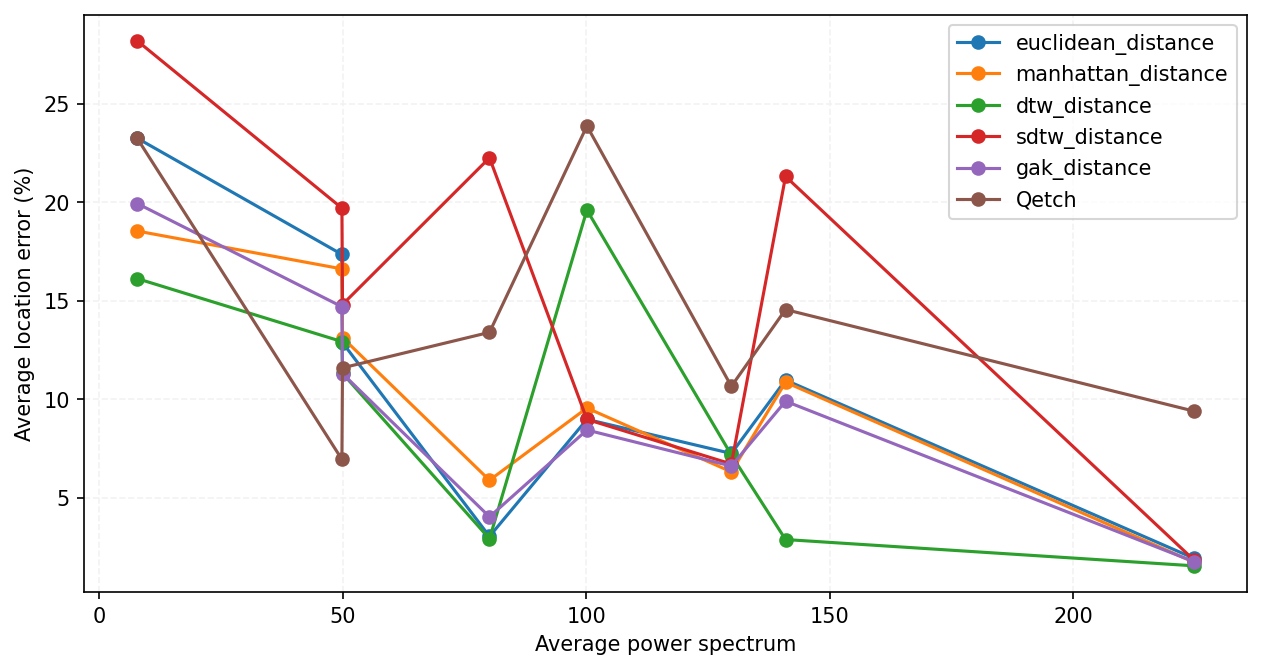

In [20]:
measures_names = [m.__name__ for m in measures] + ['Qetch']
plt.figure()
for i, method in enumerate(measures_names):
    plt.plot(df[df['Method'] == method]['Spectrum'], df[df['Method'] == method]['Average location error (%)'], label=method, marker='o')
plt.grid(color='0.95', linestyle='--')
plt.xlabel('Average power spectrum')
plt.ylabel('Average location error (%)')
plt.legend()
plt.show()

### Experiment 2: Precision Analysis

#### Precision Analysis

In [15]:
def precision_results(results, show_table = True, ori_data_X=ori_data_X, ori_data_Y=ori_data_y, datasets=datasets):
    d = {'Dataset':[], 'Precision@1':[],  'Precision@3':[], 'Precision@5':[]}
    precision_stats = np.zeros((len(results), len(results[0]), 5))
    for i in range(len(results)):
        d['Dataset'].append(datasets[i])
        for j, sktech_test in enumerate(results[i]):
            precision_stats[i, j, :] = np.argsort(np.asarray(sktech_test))[:5]
    for i in range(len(results)):
        d['Precision@1'].append(np.mean(precision_stats[i,:,0] == i) * 100) 
        d['Precision@3'].append(np.mean(np.isin(precision_stats[i,:,:3], i).any(axis = 1)) * 100) 
        d['Precision@5'].append(np.mean(np.isin(precision_stats[i,:,:], i).any(axis = 1)) * 100) 
    df = pd.DataFrame(d)
    if show_table:
        display(df)
    return df

#### Qetch get result

In [18]:
def qetch_plus_Precision(ori_data_X, ori_data_y, smoothed_sketch_list , smooth_val_stepsize):
    z = 0
    prec_output = []
    smoothed_candidate_list = []
    for i, dataset in enumerate(datasets):
        smooth_value = 0.001
        smoothed_temp = []
        while(smooth_value < 1):
            smoothed_temp.append(smoother(ori_data_X[i],smooth_value))
            smooth_value += smooth_val_stepsize
        smoothed_candidate_list.append(smoothed_temp)

    smooth_value_list = [0.001+(smooth_val_stepsize*a) for a in range(len(smoothed_candidate_list[0]))]

    for z in range(100):
        results = []
        smoothed_sketch = smoothed_sketch_list[z]
        Sketch_split_at = []
        split_sketch,k,Sketch_split_at = split_based_derivative(smoothed_sketch,True)


        for i, dataset in enumerate(datasets):
            ResultDistanceObject = []
            impossible_counter = 0
            for a in range(len(smoothed_candidate_list[i])):
                Candidate_split_at = []
                DistanceObject = []
                #Segments Loaded Data into T segments
                split_original,T,Candidate_split_at = split_based_derivative(smoothed_candidate_list[i][a],True)
                possible_check = 1
                # print("T value and k Value are: ",T,k)
                if(T<k):
                    # ResultDistanceObject.append([999,[0,0],smooth_value_list[a],i])
                    possible_check = 1
                    impossible_counter += 1
                    # print("not possible") #Need to address case where this happens -> Smoothen Sketches with too much K
                    continue
                itr = 0
                while(itr<=T-k):
                    candidate_segments = split_original[itr:k+itr]
                    query_segment = split_sketch
                    distance = calculateDistance(query_segment,candidate_segments,k)
                    #Add the starting and ending position Identified
                    start_pos = Candidate_split_at[itr]
                    end_pos = Candidate_split_at[itr+1]
                    DistanceObject.append(distance)
                    itr+=1
                # print("Distance object ",DistanceObject)
                ResultDistanceObject.append(min(DistanceObject)) # Will Contain a list of T-k minimum distances
            if(impossible_counter>0):
                print("Number of impossible Cases: ",impossible_counter," in curve - ",i,"of sketch",z)
            if(ResultDistanceObject):
                results.append(min(ResultDistanceObject))
            else:
                print("No solutions found for curve - ",i,"of sketch",z)
            # print("--- Completed a sketch --- ")
        prec_output.append(results) #Should contain 8 best minimum distances
    return prec_output

#datasets = ['has', 'sp', 'fp', 'rb', 'sd', 'sr', 'hasb', 'ihas']
all_results = []
smooth_val_stepsize = 0.1

for i in range(8):
    smoothed_sketch_list = []
    for sketch in sketch_X[i]:
        smoothed_sketch_list.append(smoother(sketch,0.3))
    all_results.append(qetch_plus_Precision(ori_data_X, ori_data_y, smoothed_sketch_list, smooth_val_stepsize))

Number of impossible Cases:  10  in curve -  3 of sketch 0
No solutions found for curve -  3 of sketch 0
Number of impossible Cases:  1  in curve -  3 of sketch 3
Number of impossible Cases:  1  in curve -  3 of sketch 4
Number of impossible Cases:  1  in curve -  3 of sketch 13
Number of impossible Cases:  3  in curve -  0 of sketch 22
Number of impossible Cases:  10  in curve -  3 of sketch 22
No solutions found for curve -  3 of sketch 22
Number of impossible Cases:  1  in curve -  6 of sketch 22
Number of impossible Cases:  2  in curve -  7 of sketch 22
Number of impossible Cases:  1  in curve -  3 of sketch 25
Number of impossible Cases:  10  in curve -  3 of sketch 26
No solutions found for curve -  3 of sketch 26
Number of impossible Cases:  1  in curve -  3 of sketch 28
Number of impossible Cases:  1  in curve -  0 of sketch 32
Number of impossible Cases:  10  in curve -  3 of sketch 32
No solutions found for curve -  3 of sketch 32
Number of impossible Cases:  1  in curve -  6

In [19]:
df_prec = precision_results(all_results)

,Dataset,Precision@1,Precision@3,Precision@5
0,has,7.0,26.0,61.0
1,sp,31.0,98.0,100.0
2,fp,17.0,99.0,99.0
3,rb,63.0,76.0,81.0
4,sd,7.0,34.0,72.0
5,sr,78.0,97.0,100.0
6,hasb,2.0,3.0,13.0
7,ihas,32.0,82.0,90.0


In [24]:
df_prec.mean()

C:\Users\vishn\AppData\Local\Temp\ipykernel_17144\569383110.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_prec.mean()


Precision@1    29.625
Precision@3    64.375
Precision@5    77.000
dtype: float64

In [35]:
measures = [euclidean_distance, manhattan_distance, dtw_distance, sdtw_distance, gak_distance]
results = []
d = {'Method':[], 'Precision@1':[],  'Precision@3':[], 'Precision@5':[]}
d1 = {'Method':[], 'has':[], 'sp':[], 'fp':[], 'rb':[], 'sd':[], 'sr':[], 'hasb':[], 'ihas':[]}
for measure in measures:
    print(f"Measure: {measure.__name__}")
    d['Method'].append(measure.__name__)
    results = pointwise_distances(ori_data_X, ori_data_y, sketch_X, measure, check_precisons = True)
    df0 = precision_results(results)
    d['Precision@1'].append(df0.iloc[:,1].mean())
    d['Precision@3'].append(df0.iloc[:,2].mean())
    d['Precision@5'].append(df0.iloc[:,3].mean())
    d1['Method'].append(measure.__name__)
    for dataset in datasets:
        d1[dataset].append(df0[df0['Dataset'] == dataset].iloc[:,3].values[0])
    print('--------------------------------------------------------')

df_prec = precision_results(all_results)
d['Method'].append("Qetch")
d['Precision@1'].append(df_prec.iloc[:,1].mean())
d['Precision@3'].append(df_prec.iloc[:,2].mean())
d['Precision@5'].append(df_prec.iloc[:,3].mean())
d1['Method'].append("Qetch")
for dataset in datasets:
    d1[dataset].append(df_prec[df_prec['Dataset'] == dataset].iloc[:,3].values[0])

df = pd.DataFrame(d)
df1 = pd.DataFrame(d1)
display(df)
display(df1)
experiment_name = 'exp2'
np.save('./experiment_results/' + experiment_name + '.npy', results)

Measure: euclidean_distance


,Dataset,Precision@1,Precision@3,Precision@5
0,has,38.0,88.0,98.0
1,sp,13.0,19.0,22.0
2,fp,30.0,48.0,70.0
3,rb,84.0,97.0,97.0
4,sd,73.0,88.0,100.0
5,sr,36.0,52.0,65.0
6,hasb,0.0,20.0,98.0
7,ihas,57.0,93.0,100.0


--------------------------------------------------------
Measure: manhattan_distance


,Dataset,Precision@1,Precision@3,Precision@5
0,has,0.0,2.0,58.0
1,sp,3.0,9.0,20.0
2,fp,17.0,33.0,75.0
3,rb,78.0,89.0,97.0
4,sd,90.0,99.0,100.0
5,sr,61.0,95.0,99.0
6,hasb,1.0,71.0,100.0
7,ihas,19.0,78.0,100.0


--------------------------------------------------------
Measure: dtw_distance


,Dataset,Precision@1,Precision@3,Precision@5
0,has,19.0,64.0,97.0
1,sp,42.0,86.0,91.0
2,fp,67.0,93.0,97.0
3,rb,75.0,92.0,97.0
4,sd,67.0,90.0,95.0
5,sr,35.0,89.0,99.0
6,hasb,0.0,7.0,34.0
7,ihas,84.0,95.0,99.0


--------------------------------------------------------
Measure: sdtw_distance


,Dataset,Precision@1,Precision@3,Precision@5
0,has,100.0,100.0,100.0
1,sp,0.0,100.0,100.0
2,fp,0.0,0.0,100.0
3,rb,0.0,100.0,100.0
4,sd,0.0,0.0,0.0
5,sr,0.0,0.0,0.0
6,hasb,0.0,0.0,0.0
7,ihas,0.0,0.0,100.0


--------------------------------------------------------
Measure: gak_distance


,Dataset,Precision@1,Precision@3,Precision@5
0,has,5.0,43.0,71.0
1,sp,4.0,14.0,39.0
2,fp,39.0,77.0,99.0
3,rb,81.0,90.0,94.0
4,sd,85.0,92.0,100.0
5,sr,80.0,89.0,93.0
6,hasb,1.0,22.0,54.0
7,ihas,43.0,76.0,95.0


--------------------------------------------------------


,Dataset,Precision@1,Precision@3,Precision@5
0,has,7.0,26.0,61.0
1,sp,31.0,98.0,100.0
2,fp,17.0,99.0,99.0
3,rb,63.0,76.0,81.0
4,sd,7.0,34.0,72.0
5,sr,78.0,97.0,100.0
6,hasb,2.0,3.0,13.0
7,ihas,32.0,82.0,90.0


,Method,Precision@1,Precision@3,Precision@5
0,euclidean_distance,41.375,63.125,81.250
1,manhattan_distance,33.625,59.500,81.125
2,dtw_distance,48.625,77.000,88.625
3,sdtw_distance,12.500,37.500,62.500
4,gak_distance,42.250,62.875,80.625
5,Qetch,29.625,64.375,77.000


,Method,has,sp,fp,rb,sd,sr,hasb,ihas
0,euclidean_distance,98.0,22.0,70.0,97.0,100.0,65.0,98.0,100.0
1,manhattan_distance,58.0,20.0,75.0,97.0,100.0,99.0,100.0,100.0
2,dtw_distance,97.0,91.0,97.0,97.0,95.0,99.0,34.0,99.0
3,sdtw_distance,100.0,100.0,100.0,100.0,0.0,0.0,0.0,100.0
4,gak_distance,71.0,39.0,99.0,94.0,100.0,93.0,54.0,95.0
5,Qetch,61.0,100.0,99.0,81.0,72.0,100.0,13.0,90.0


#### Plot Precision Distrubution

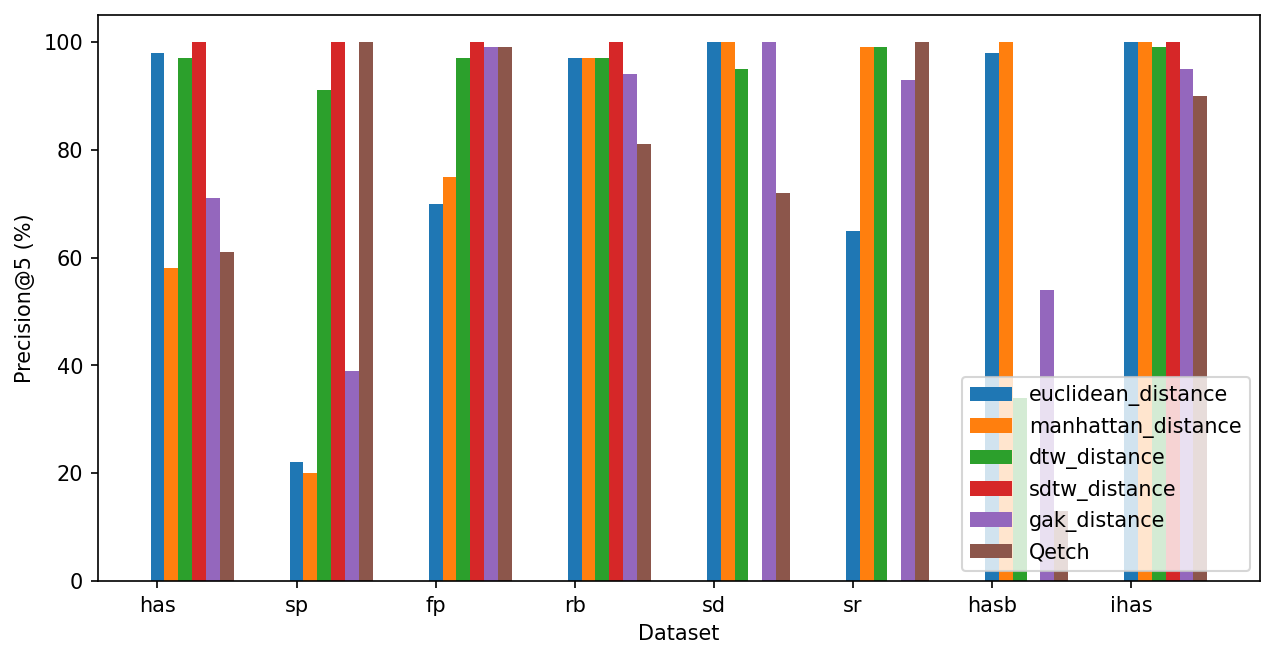

In [36]:
plt.figure()
measures_names = [m.__name__ for m in measures] + ['Qetch']
x = np.arange(len(datasets))
w = 0.1
for i, plot_data in enumerate(df1.to_numpy()):
    plt.bar(x + 0.1 * i, plot_data[1:], w, label = plot_data[0])
plt.xticks(x, datasets)
plt.legend(bbox_to_anchor=(1,0), loc='lower right')
plt.xlabel('Dataset')
plt.ylabel('Precision@5 (%)')
plt.show()

### Experiment 3: Matching Performance with Different Level of Noise in Original Time Series

##### Noise in Original Time Series

In [24]:
measures = [euclidean_distance, manhattan_distance, dtw_distance, sdtw_distance, gak_distance]
# measures = []
d = {'sigma':[], 'Method':[], 'Average location error (%)':[]}
sigmas = [0,  5, 10, 15, 20]
for sigma in sigmas:
    print(f"Sigma: {sigma}")
    ori_data_X0 = [x + np.random.randn(*x.shape) * sigma / 100 * np.std(x) for x in ori_data_X]
    for measure in measures:
        print(f"Measure: {measure.__name__}")
        d['sigma'].append(sigma)
        d['Method'].append(measure.__name__)
        results = pointwise_distances(ori_data_X0, ori_data_y, sketch_X, measure)
        df = accuracy_results(results, plot = False, show_table = False)
        d['Average location error (%)'].append(df.iloc[:,3].mean())
        print('--------------------------------------------------------')
    error = []
    smooth_val_stepsize = 0.05
    for i in range(8):
        error.append(qetch_plus_accuracy(ori_data_X0, ori_data_y, sketch_X, smooth_val_stepsize, i))
    d['Method'].append("Qetch")
    d['sigma'].append(sigma)
    d['Average location error (%)'].append(np.mean(error))
experiment_name = 'exp3'
np.save('./experiment_results/' + experiment_name + '.npy', results)
df = pd.DataFrame(d)
display(df)

Sigma: 0
Measure: euclidean_distance
--------------------------------------------------------
Measure: manhattan_distance
--------------------------------------------------------
Measure: dtw_distance
--------------------------------------------------------
Measure: sdtw_distance
--------------------------------------------------------
Measure: gak_distance
--------------------------------------------------------
Sigma: 5
Measure: euclidean_distance
--------------------------------------------------------
Measure: manhattan_distance
--------------------------------------------------------
Measure: dtw_distance
--------------------------------------------------------
Measure: sdtw_distance
--------------------------------------------------------
Measure: gak_distance
--------------------------------------------------------
Sigma: 10
Measure: euclidean_distance
--------------------------------------------------------
Measure: manhattan_distance
-------------------------------------------

,sigma,Method,Average location error (%)
0,0,euclidean_distance,10.706529
1,0,manhattan_distance,10.330958
2,0,dtw_distance,9.313138
3,0,sdtw_distance,15.471829
4,0,gak_distance,9.586080
5,0,Qetch,14.205751
6,5,euclidean_distance,11.218764
7,5,manhattan_distance,10.787741
8,5,dtw_distance,10.407572
9,5,sdtw_distance,15.772346


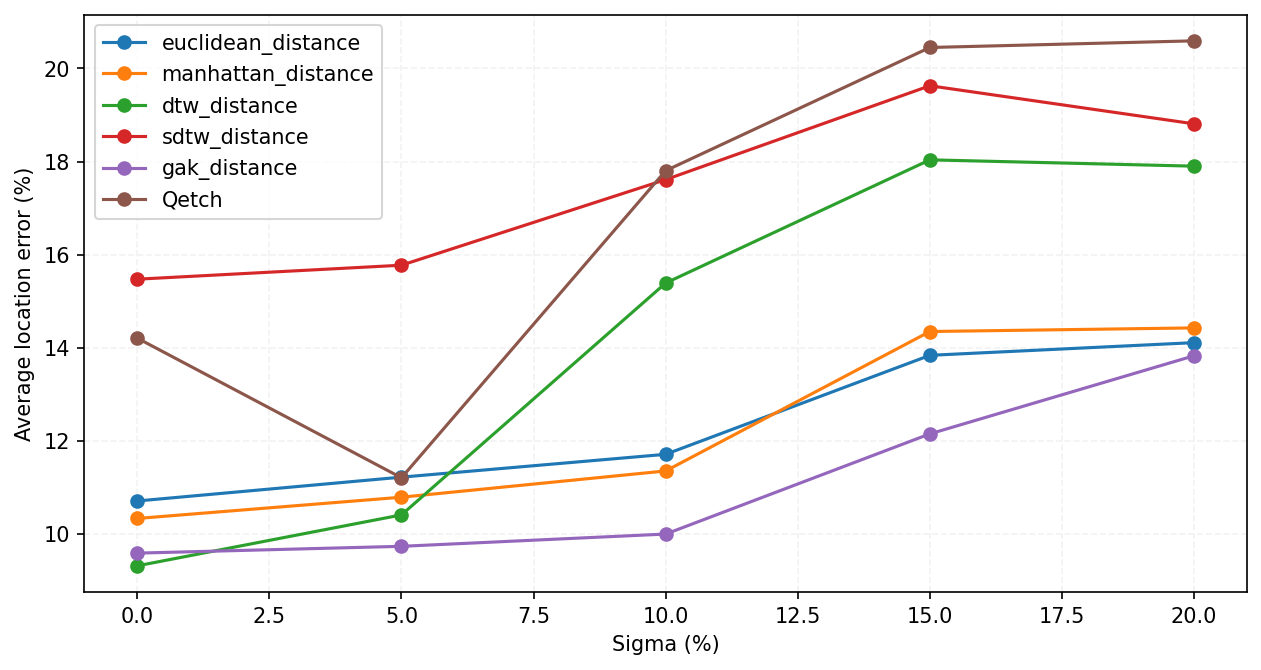

In [25]:
measures_names = [m.__name__ for m in measures] + ['Qetch']
plt.figure()
for method in measures_names:
    plt.plot(df[df['Method'] == method]['sigma'], df[df['Method'] == method]['Average location error (%)'], label=method, marker='o')
plt.grid(color='0.95', linestyle='--')
plt.xlabel('Sigma (%)')
plt.ylabel('Average location error (%)')
plt.legend()
plt.show()

##### Noise in Sketches

In [26]:
measures = [euclidean_distance, manhattan_distance, dtw_distance, sdtw_distance, gak_distance]
# measures = [euclidean_distance]
d = {'sigma':[], 'Method':[], 'Average location error (%)':[]}
sigmas = [0, 0.1, 0.2, 0.3, 1]
sigmas = [0,  5, 10, 15, 20]
for sigma in sigmas:
    print(f"Sigma: {sigma}")
    # ori_data_X = [x + np.random.normal(0, sigma, x.shape) for x in ori_data_X]
    sketch_X0 = [[x + np.random.randn(*x.shape) * sigma / 100 * np.std(x) for x in xx] for xx in sketch_X]
    for measure in measures:
        print(f"Measure: {measure.__name__}")
        d['sigma'].append(sigma)
        d['Method'].append(measure.__name__)
        results = pointwise_distances(ori_data_X, ori_data_y, sketch_X0, measure)
        df = accuracy_results(results, plot = False, show_table = False)
        d['Average location error (%)'].append(df.iloc[:,3].mean())
        print('--------------------------------------------------------')
df = pd.DataFrame(d)
display(df)

Sigma: 0
Measure: euclidean_distance
--------------------------------------------------------
Measure: manhattan_distance
--------------------------------------------------------
Measure: dtw_distance
--------------------------------------------------------
Measure: sdtw_distance
--------------------------------------------------------
Measure: gak_distance
--------------------------------------------------------
Sigma: 5
Measure: euclidean_distance
--------------------------------------------------------
Measure: manhattan_distance
--------------------------------------------------------
Measure: dtw_distance
--------------------------------------------------------
Measure: sdtw_distance
--------------------------------------------------------
Measure: gak_distance
--------------------------------------------------------
Sigma: 10
Measure: euclidean_distance
--------------------------------------------------------
Measure: manhattan_distance
-------------------------------------------

,sigma,Method,Average location error (%)
0,0,euclidean_distance,10.706529
1,0,manhattan_distance,10.330958
2,0,dtw_distance,9.313138
3,0,sdtw_distance,15.471829
4,0,gak_distance,9.586080
5,5,euclidean_distance,10.741250
6,5,manhattan_distance,10.343075
7,5,dtw_distance,9.349670
8,5,sdtw_distance,15.505260
9,5,gak_distance,9.724966


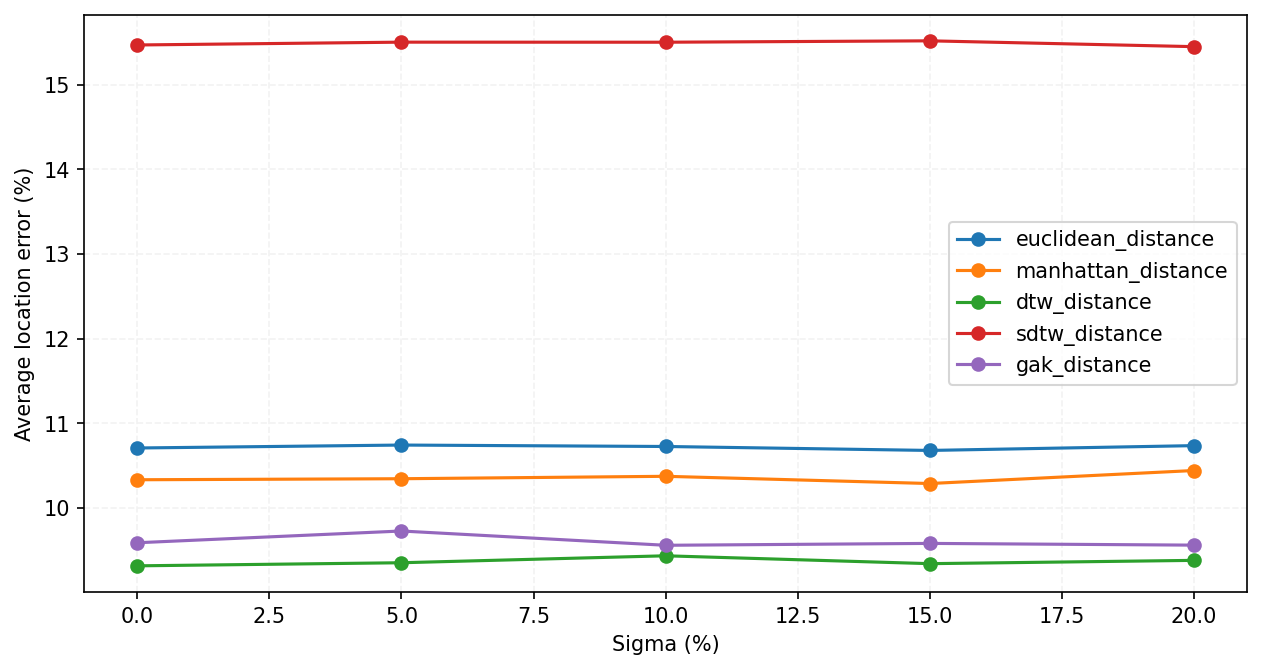

In [27]:
measures_names = [m.__name__ for m in measures]
plt.figure()
for method in measures_names:
    plt.plot(df[df['Method'] == method]['sigma'], df[df['Method'] == method]['Average location error (%)'], label=method, marker='o')
plt.grid(color='0.95', linestyle='--')
plt.xlabel('Sigma (%)')
plt.ylabel('Average location error (%)')
plt.legend()
plt.show()